**1. Checking for Assumptions**

Loading and preparing the dataset

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# --- Global Seed Setup (type this once!) ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [2]:
# STEP 1: Load Libraries and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Brouwer Mean Motion from Fengyun-2F CSV
df = pd.read_csv('/content/Sentinel-3A.csv')
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

# --- Load and parse ground truth maneuver timestamps ---
truth_df = pd.read_excel("/content/cleaned_s3aman.xlsx")
ground_truth_timestamps = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# Select relevant column
bmm_series = df['Brouwer mean motion']


2. Checking Regualrity

In [3]:
# STEP 2: Resample to daily data
bmm_daily = bmm_series.resample('D').mean()

# Check missing values
missing_days = bmm_daily.isnull().sum()
print(f"Missing daily entries: {missing_days}")



Missing daily entries: 16


3. Interpolating missing values

In [4]:
# STEP 3: Fill gaps using linear interpolation
bmm_filled = bmm_daily.interpolate(method='linear')

bmm_filled = bmm_filled * 1e6

# Confirm fill
print("Any missing after interpolation?", bmm_filled.isnull().any())



Any missing after interpolation? False


4. Apply differencing

In [5]:
bmm_filled = bmm_filled.diff().dropna()
print("Differencing applied. First few values:")
print(bmm_filled.head())

Differencing applied. First few values:
timestamp
2016-03-05   -0.012897
2016-03-06   -0.039667
2016-03-07   -0.013345
2016-03-08   -0.001005
2016-03-09    0.091645
Freq: D, Name: Brouwer mean motion, dtype: float64


In [6]:
# STEP 6: Check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(bmm_filled.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("✅ The series is stationary (p < 0.05)")
else:
    print("❌ The series is NOT stationary (p ≥ 0.05)")


ADF Statistic: -19.75411609870589
p-value: 0.0
✅ The series is stationary (p < 0.05)


6. Checking Time gaps

In [7]:
# Ensure uniform time spacing
time_deltas = bmm_filled.index.to_series().diff().value_counts()
print("Time step distribution:")
print(time_deltas.head())


Time step distribution:
timestamp
1 days    2399
Name: count, dtype: int64


7. Visualisation

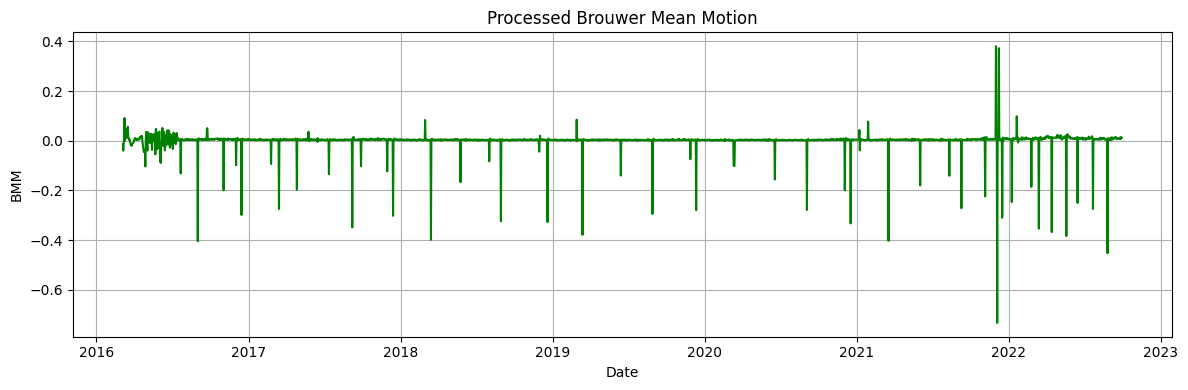

In [8]:
# STEP 8: Plot raw (interpolated + optionally differenced) BMM
plt.figure(figsize=(12, 4))
plt.plot(bmm_filled.index, bmm_filled.values, color='green')
plt.title("Processed Brouwer Mean Motion")
plt.ylabel("BMM")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


**2. Fitting of XGBoost model**

In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- Utility: Create lagged features ---
def make_lagged_features(series, lag=7):
    df_lagged = pd.DataFrame({'target': series})
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = series.shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

# Dictionary to store Optuna studies and histories for each lag
lag_study_results = {}



In [11]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# --- Fix random seed for reproducibility ---
SEED = 42

# Store results for each lag
lag_study_results = {}

# Define lags to evaluate
lag_values = [5,10,15,20,50]

for LAG in lag_values:
    print(f"\n🚀 Running Optuna for LAG={LAG}")

    # --- Create lagged features ---
    lagged_df = make_lagged_features(bmm_filled, lag=LAG)

    # --- Train-test split ---
    train_size = int(len(lagged_df) * 0.8)
    train_df = lagged_df.iloc[:train_size]
    test_df = lagged_df.iloc[train_size:]

    X_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    X_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # --- Define objective function for Optuna ---
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
            'random_state': SEED,
            'objective': 'reg:squarederror'
        }
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    # --- Create and run Optuna study with seeded sampler ---
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # --- Store results ---
    lag_study_results[LAG] = {
        "study": study,
        "best_params": study.best_params,
        "best_value": study.best_value
    }


[I 2025-08-14 04:49:11,715] A new study created in memory with name: no-name-4dddf493-39fc-468a-8bd4-7dc7cc4939aa



🚀 Running Optuna for LAG=5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 04:49:11,936] Trial 0 finished with value: 0.004073515653229782 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004073515653229782.
[I 2025-08-14 04:49:11,972] Trial 1 finished with value: 0.004073542028073036 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.004073515653229782.
[I 2025-08-14 04:49:11,994] Trial 2 finished with value: 0.004073536610379327 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 04:49:14,790] A new study created in memory with name: no-name-52b6c6a8-670c-4566-8b21-92fd594a9e17


[I 2025-08-14 04:49:14,648] Trial 47 finished with value: 0.004073521410286062 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.10330141142342394, 'subsample': 0.852440773882755, 'colsample_bytree': 0.7132056052239171, 'gamma': 0.41776386490383793, 'reg_alpha': 0.4664115906650488, 'reg_lambda': 0.20757465773695935}. Best is trial 43 with value: 0.004073442027483631.
[I 2025-08-14 04:49:14,714] Trial 48 finished with value: 0.004073485160735101 and parameters: {'n_estimators': 173, 'max_depth': 6, 'learning_rate': 0.0426410625155521, 'subsample': 0.7760499454566014, 'colsample_bytree': 0.6859787718346072, 'gamma': 3.8851082887005712, 'reg_alpha': 0.7319977133380866, 'reg_lambda': 0.42494187101954844}. Best is trial 43 with value: 0.004073442027483631.
[I 2025-08-14 04:49:14,779] Trial 49 finished with value: 0.004073504863675532 and parameters: {'n_estimators': 167, 'max_depth': 7, 'learning_rate': 0.012676501253318668, 'subsample': 0.7369984976130746, 'colsample

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 04:49:14,833] Trial 0 finished with value: 0.004082011341546315 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004082011341546315.
[I 2025-08-14 04:49:14,870] Trial 1 finished with value: 0.004082066857706448 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.004082011341546315.
[I 2025-08-14 04:49:14,899] Trial 2 finished with value: 0.0040820567592394765 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsam

[I 2025-08-14 04:49:18,896] A new study created in memory with name: no-name-23470cac-18a3-4c0b-8d42-3bec7b4bad3b


[I 2025-08-14 04:49:18,883] Trial 49 finished with value: 0.004081971689204494 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.07280520401411301, 'subsample': 0.6013644096274852, 'colsample_bytree': 0.7197236988071333, 'gamma': 4.967411011074679, 'reg_alpha': 0.38635685053532676, 'reg_lambda': 0.6827578434872235}. Best is trial 27 with value: 0.004081938795512987.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 04:49:18,943] Trial 0 finished with value: 0.004090750933732612 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004090750933732612.
[I 2025-08-14 04:49:18,981] Trial 1 finished with value: 0.0040906673054626344 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0040906673054626344.
[I 2025-08-14 04:49:19,013] Trial 2 finished with value: 0.004090672801950399 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsa

[I 2025-08-14 04:49:22,459] A new study created in memory with name: no-name-69d516f5-8fb5-4e43-b436-562128bbf444


[I 2025-08-14 04:49:22,444] Trial 49 finished with value: 0.00409060098639343 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.10670908320511226, 'subsample': 0.721646027303734, 'colsample_bytree': 0.705898941363694, 'gamma': 4.2438612386158585, 'reg_alpha': 0.38635685053532676, 'reg_lambda': 0.2817253292186165}. Best is trial 10 with value: 0.004090479967931486.

🚀 Running Optuna for LAG=20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 04:49:22,511] Trial 0 finished with value: 0.004099214319981026 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004099214319981026.
[I 2025-08-14 04:49:22,552] Trial 1 finished with value: 0.004099204725068331 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.004099204725068331.
[I 2025-08-14 04:49:22,586] Trial 2 finished with value: 0.004099199129373294 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 04:49:26,181] A new study created in memory with name: no-name-5db19aff-25b3-49fc-8abc-56e8eacecb16


[I 2025-08-14 04:49:26,156] Trial 49 finished with value: 0.004099177889816333 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.20852778881800038, 'subsample': 0.988293088919235, 'colsample_bytree': 0.9508898321800193, 'gamma': 0.8171476210390889, 'reg_alpha': 0.6468766100217804, 'reg_lambda': 0.3980890563641335}. Best is trial 20 with value: 0.004099072713024698.

🚀 Running Optuna for LAG=50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 04:49:26,249] Trial 0 finished with value: 0.004151267229863532 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004151267229863532.
[I 2025-08-14 04:49:26,310] Trial 1 finished with value: 0.004151264333972639 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.004151264333972639.
[I 2025-08-14 04:49:26,362] Trial 2 finished with value: 0.004151280359057328 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

In [12]:
print("\n📘 Summary of Optuna Results by Lag:\n")

for lag_val, result in lag_study_results.items():
    print(f"\n🌀 LAG = {lag_val}")
    print(f"Best MSE: {result['best_value']:.6f}")
    print("Best Parameters:")
    for k, v in result['best_params'].items():
        print(f"  {k}: {v}")





📘 Summary of Optuna Results by Lag:


🌀 LAG = 5
Best MSE: 0.004073
Best Parameters:
  n_estimators: 170
  max_depth: 6
  learning_rate: 0.27129222695980015
  subsample: 0.7835499391644245
  colsample_bytree: 0.6786072988012457
  gamma: 1.0150656425368878
  reg_alpha: 0.6361310147278245
  reg_lambda: 0.4305401941703333

🌀 LAG = 10
Best MSE: 0.004082
Best Parameters:
  n_estimators: 140
  max_depth: 7
  learning_rate: 0.13815047300788236
  subsample: 0.555852567387078
  colsample_bytree: 0.7390135402481219
  gamma: 2.0120003222547718
  reg_alpha: 0.5267426265770458
  reg_lambda: 0.4420193752556448

🌀 LAG = 15
Best MSE: 0.004090
Best Parameters:
  n_estimators: 287
  max_depth: 10
  learning_rate: 0.2350704805592213
  subsample: 0.5089809378074097
  colsample_bytree: 0.698604538182231
  gamma: 2.28163786900188
  reg_alpha: 0.9597707459454197
  reg_lambda: 0.6765723797427796

🌀 LAG = 20
Best MSE: 0.004099
Best Parameters:
  n_estimators: 209
  max_depth: 9
  learning_rate: 0.1328899067375

In [13]:
from xgboost import XGBRegressor

# --- Storage for final models and residuals ---
final_models = {}
residuals_per_lag = {}

# --- Loop over each lag from tuning history ---
for LAG, result in lag_study_results.items():
    print(f"\n📦 Retraining model on full data for LAG = {LAG}...")

    # Step 1: Recreate lagged dataframe
    lagged_df = pd.DataFrame({'target': bmm_filled})
    for i in range(1, LAG + 1):
        lagged_df[f'lag_{i}'] = bmm_filled.shift(i)
    lagged_df.dropna(inplace=True)

    # Step 2: Prepare full dataset
    X_full = lagged_df.drop("target", axis=1).values
    y_full = lagged_df["target"].values

    # Step 3: Load best parameters and create model
    best_params = result["best_params"].copy()
    best_params.update({
        "objective": "reg:squarederror",
        "random_state": SEED
    })

    model = XGBRegressor(**best_params)
    model.fit(X_full, y_full)

    # Step 4: Store model and residuals
    final_models[LAG] = model
    y_pred = model.predict(X_full)
    residuals = y_full - y_pred
    residuals_per_lag[LAG] = pd.Series(residuals, index=lagged_df.index)

    print(f"✅ Model trained and residuals saved for LAG = {LAG}")



📦 Retraining model on full data for LAG = 5...
✅ Model trained and residuals saved for LAG = 5

📦 Retraining model on full data for LAG = 10...
✅ Model trained and residuals saved for LAG = 10

📦 Retraining model on full data for LAG = 15...
✅ Model trained and residuals saved for LAG = 15

📦 Retraining model on full data for LAG = 20...
✅ Model trained and residuals saved for LAG = 20

📦 Retraining model on full data for LAG = 50...
✅ Model trained and residuals saved for LAG = 50


**3. Qualitative Analysis**

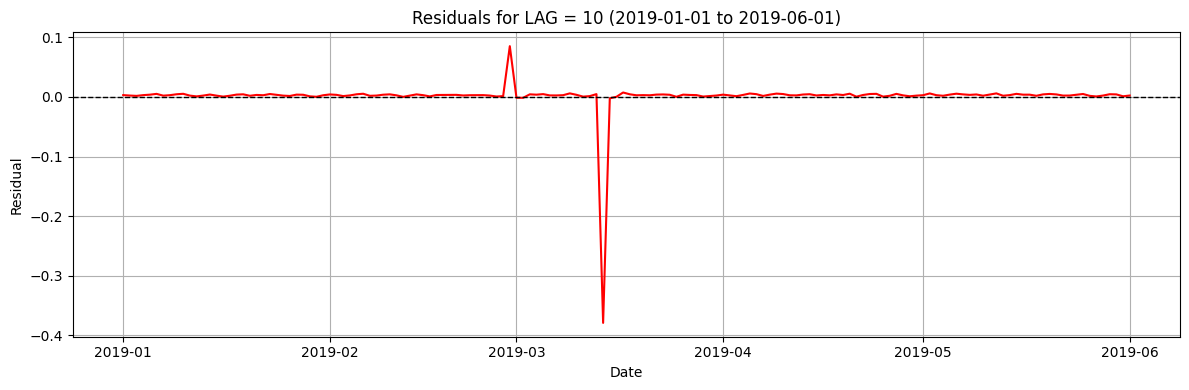

In [14]:
import matplotlib.pyplot as plt

def plot_residuals_for_lag(lag):
    """
    Plots residuals for a given lag using a fixed time window.

    Parameters:
        lag (int): The lag value whose residuals you want to visualize.
    """
    if lag not in residuals_per_lag:
        print(f"❌ Lag {lag} not found in residuals_per_lag.")
        return

    # Fixed time window
    start_date = "2019-01-01"
    end_date = "2019-06-01"

    # Get residuals and slice to window
    residual_series = residuals_per_lag[lag]
    residual_window = residual_series.loc[start_date:end_date]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(residual_window.index, residual_window.values, color="red")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residuals for LAG = {lag} ({start_date} to {end_date})")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_residuals_for_lag(10)


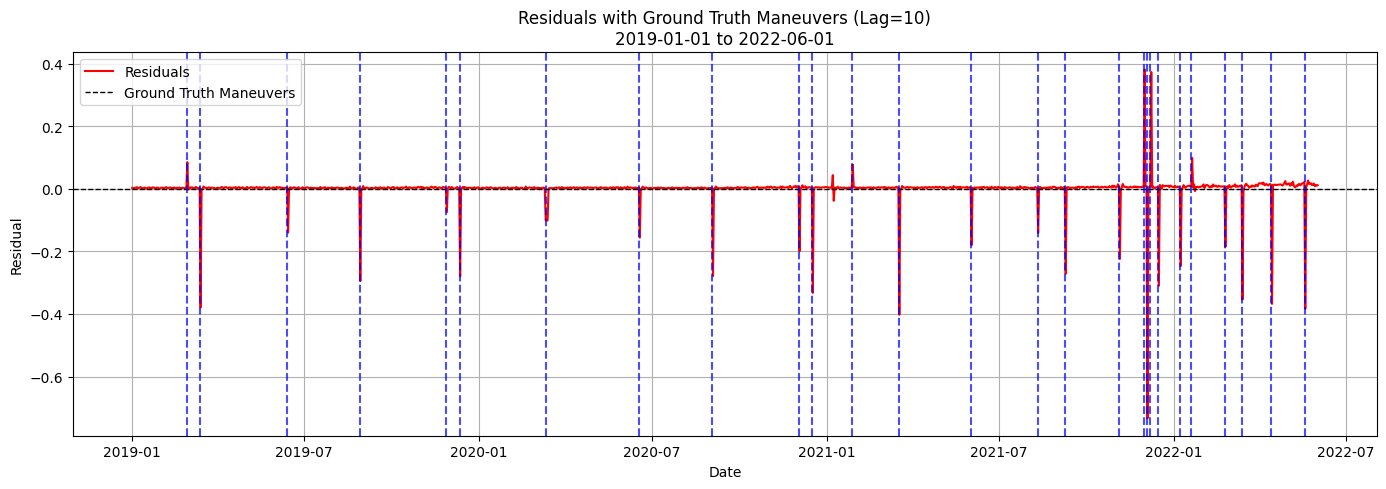

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and parse ground truth maneuver timestamps ---
truth_df = pd.read_excel("/content/cleaned_s3aman.xlsx")
ground_truth_timestamps = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# --- Define plot function for a given lag ---
def plot_residuals_with_gt_for_lag(lag):
    """
    Plot residuals with ground truth maneuver overlay for a given lag.
    Uses fixed time window from 2013-01-01 to 2013-03-01.
    """
    if lag not in residuals_per_lag:
        print(f"❌ Residuals not found for lag {lag}")
        return

    # Fixed time window
    start_date = "2019-01-01"
    end_date = "2022-06-01"

    # Get residuals for the specified lag
    residual_series = residuals_per_lag[lag]
    residual_window = residual_series.loc[start_date:end_date]

    # Filter ground truth maneuvers to the window
    gt_in_window = ground_truth_timestamps[
        (ground_truth_timestamps >= pd.to_datetime(start_date)) &
        (ground_truth_timestamps <= pd.to_datetime(end_date))
    ]

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(residual_window.index, residual_window.values, color='red', label='Residuals')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    for ts in gt_in_window:
        plt.axvline(ts, color='blue', linestyle='--', alpha=0.7)

    plt.title(f"Residuals with Ground Truth Maneuvers (Lag={lag})\n{start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.legend(["Residuals", "Ground Truth Maneuvers"])
    plt.tight_layout()
    plt.show()

# --- Example usage ---
plot_residuals_with_gt_for_lag(10)


**4. Quantitative Analysis**

/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

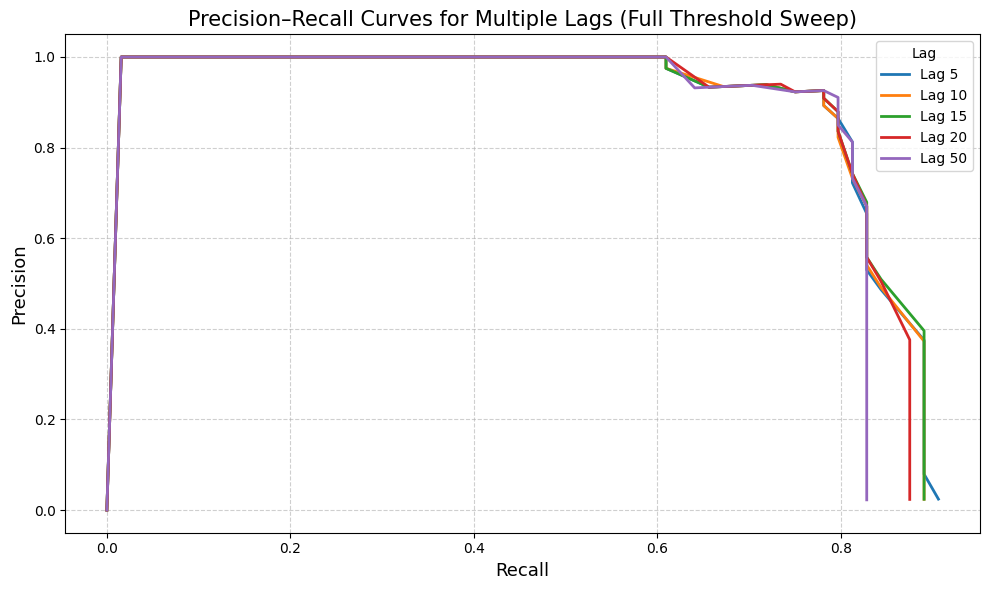

,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,50,0.050056,0.910714,0.796875,0.850000,51,5,13,0.796224
1,5,0.059084,0.925926,0.781250,0.847458,50,4,14,0.823523
2,10,0.059081,0.925926,0.781250,0.847458,50,4,14,0.824945
3,15,0.059080,0.925926,0.781250,0.847458,50,4,14,0.825878
4,20,0.059069,0.925926,0.781250,0.847458,50,4,14,0.819968


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Precision / Recall / F1 Computation ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN


# --- Evaluation and PR Plot ---
summary_rows = []
lag_metrics_dfs = {}  # Store metrics per lag for later scenario analysis
plt.figure(figsize=(10, 6))
matching_window_days = 3.0

for lag, residual_series in residuals_per_lag.items():
    abs_resid = residual_series.abs()

    # FULL RANGE sweep from min to max
    thresholds = np.linspace(
        abs_resid.min(),
        abs_resid.max(),
        150
    )

    pr_points = []
    metrics = []

    for threshold in thresholds:
        precision, recall, f1, TP, FP, FN = compute_prf_simple(
            abs_resid,
            ground_truth_timestamps,
            threshold,
            matching_window_days=matching_window_days
        )
        pr_points.append((recall, precision))
        metrics.append((threshold, precision, recall, f1, TP, FP, FN))

    # Convert to DataFrame to extract best row
    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
    best_idx = metrics_df["F1"].idxmax()
    best_row = metrics_df.loc[best_idx]

    # Compute AUC using trapezoidal rule
    pr_points_arr = np.array(pr_points)
    sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
    auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall

    # Add to summary table
    summary_rows.append({
        "Lag": lag,
        "Best Threshold": best_row["Threshold"],
        "Precision": best_row["Precision"],
        "Recall": best_row["Recall"],
        "F1 Score": best_row["F1"],
        "TP": int(best_row["TP"]),
        "FP": int(best_row["FP"]),
        "FN": int(best_row["FN"]),
        "PR AUC": auc_pr
    })

    # Save full metrics for this lag
    lag_metrics_dfs[lag] = metrics_df.copy()

    # Plot PR curve
    plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"Lag {lag}", linewidth=2)

# --- PR Curve Plot ---
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision–Recall Curves for Multiple Lags (Full Threshold Sweep)", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lag", fontsize=10)
plt.tight_layout()
plt.show()

# --- Summary Table ---
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("F1 Score", ascending=False).reset_index(drop=True)

from IPython.display import display
display(summary_df)



📋 === Sentinel-3A Data Diagnostics ===
📊 Target Variable Stats:
Mean               : 0.00011987522453940377
Standard Deviation : 0.04099951770714639

🔁 Plotting Autocorrelation...


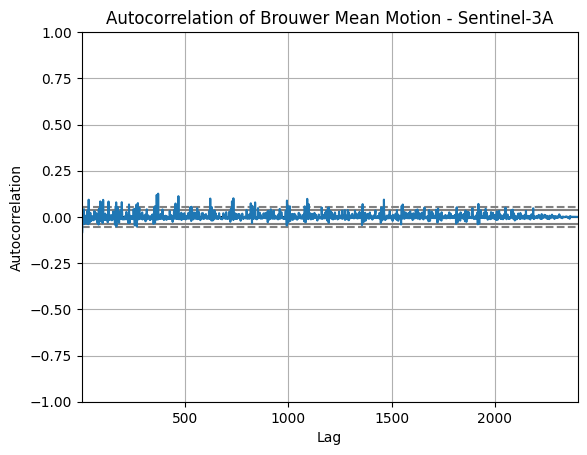


📅 Ground Truth Alignment Check:
Data Range         : 2016-03-05 00:00:00 → 2022-09-29 00:00:00
GT Timestamp Range : 2016-02-22 09:30:00 → 2022-10-06 07:00:00
✅ GT timestamps inside data range: 58

📈 Plotting Mean Motion Time Series...


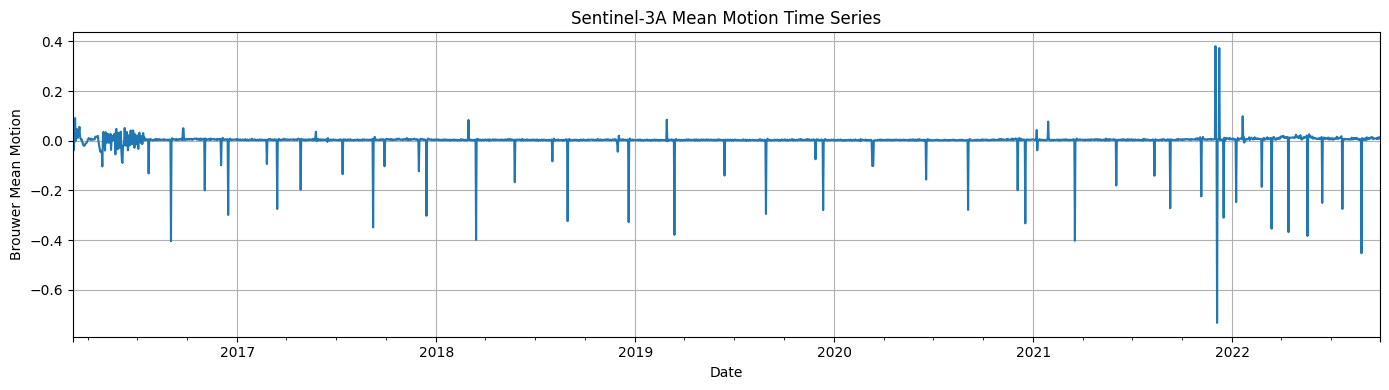

In [17]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

print("\n📋 === Sentinel-3A Data Diagnostics ===")

# --- 1. Target Stats ---
print("📊 Target Variable Stats:")
print("Mean               :", bmm_filled.mean())
print("Standard Deviation :", bmm_filled.std())

# --- 2. Autocorrelation Plot ---
print("\n🔁 Plotting Autocorrelation...")
autocorrelation_plot(bmm_filled)
plt.title("Autocorrelation of Brouwer Mean Motion - Sentinel-3A")
plt.grid(True)
plt.show()

# --- 3. Ground Truth Alignment ---
print("\n📅 Ground Truth Alignment Check:")
data_start = bmm_filled.index.min()
data_end = bmm_filled.index.max()
print("Data Range         :", data_start, "→", data_end)
print("GT Timestamp Range :", ground_truth_timestamps.min(), "→", ground_truth_timestamps.max())

gt_filtered = ground_truth_timestamps[
    (ground_truth_timestamps >= data_start) &
    (ground_truth_timestamps <= data_end)
]
print("✅ GT timestamps inside data range:", len(gt_filtered))
if len(gt_filtered) == 0:
    print("⚠️ WARNING: No ground truth maneuvers align with the Sentinel-3A data range!")

# --- 4. Visualize Mean Motion ---
print("\n📈 Plotting Mean Motion Time Series...")
bmm_filled.plot(figsize=(14,4), title="Sentinel-3A Mean Motion Time Series")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Brouwer Mean Motion")
plt.tight_layout()
plt.show()
